### Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

In [2]:
data = pd.read_csv("Data_stock_SCS_VN.csv")

In [3]:
# Chia nhỏ giá trị cho 1000 để lúc minimize không bị overflow khi tính exp
data[['open','high','close','low']] = data[['open','high','close','low']].apply(lambda x: x/1000)

data['mean'] = (data['high']-data['low'])/2
data['sd'] = data[['open', 'high', 'low', 'close']].std(axis=1)
data['time'] = pd.to_datetime(data['time'], format='%Y-%m-%d')
data['doy'] = data['time'].dt.dayofyear

data

,time,open,high,low,close,volume,mean,sd,doy
0,2019-03-01,59.96,59.96,59.92,59.96,34010,0.020,0.020000,60
1,2019-03-04,59.96,60.08,58.98,59.96,8580,0.550,0.513128,63
2,2019-03-05,58.72,60.01,58.72,59.96,35720,0.645,0.730633,64
3,2019-03-06,59.96,60.13,59.96,59.96,9290,0.085,0.085000,65
4,2019-03-07,59.96,60.40,59.96,60.33,19290,0.220,0.235567,66
...,...,...,...,...,...,...,...,...,...
1248,2024-02-23,75.00,75.40,73.60,73.80,91600,0.900,0.885061,54
1249,2024-02-26,74.00,75.50,73.80,75.40,95900,0.850,0.899537,57
1250,2024-02-27,75.40,76.00,74.00,74.70,39400,1.000,0.865544,58
1251,2024-02-28,74.50,75.70,74.50,75.50,63500,0.600,0.640312,59


In [4]:
split = int(len(data)*0.9)
train = data[:split]
test = data[split:]

In [5]:
# Get necessary values
doy = train['doy']
obs = train['close']
m = train['mean']
s = train['sd']

In [6]:
sin1 = np.round(np.sin(2 * np.pi * doy / 365.25), 3)
sin2 = np.round(np.sin(4 * np.pi * doy / 365.25), 3)
cos1 = np.round(np.cos(2 * np.pi * doy / 365.25), 3)
cos2 = np.round(np.cos(4 * np.pi * doy / 365.25), 3)

doys_array = np.hstack((np.ones((doy.shape[0], 1)), np.column_stack((sin1, sin2, cos1, cos2))))

In [7]:
df = pd.DataFrame({'close': train['close'], 'mean': m, 'sin1': sin1, 'sin2': sin2, 'cos1': cos1, 'cos2': cos2})

df['sin1_mean'] = df['sin1'] * df['mean']
df['sin2_mean'] = df['sin2'] * df['mean']
df['cos1_mean'] = df['cos1'] * df['mean']
df['cos2_mean'] = df['cos2'] * df['mean']

columns = ['sin1','sin2','cos1','cos2','mean','sin1_mean','sin2_mean','cos1_mean','cos2_mean']
x_train = df[columns]
y_train = train['close']

model = Lasso(alpha=0.1)
model.fit(x_train, y_train)

Lasso(alpha=0.1)

### Optimization

In [8]:
arr = np.concatenate([[model.intercept_], model.coef_])
pars = np.concatenate([arr, [0,0,0,0,0,1,0,0,0,0]])

In [9]:
def optim_fun(pars, obs, m, s, doys):
    MU = np.dot(doys, pars[:5]) + np.dot(doys, pars[5:10]) * m
    SIGMA = np.dot(doys, pars[10:15]) + np.dot(doys, pars[15:20]) * s
    
    # Calculate z
    z = (obs - MU) / SIGMA

    # Calculate CRPS
    crps = SIGMA * (z * (2 * norm.cdf(z) - 1) + 2 * norm.pdf(z) - 1 / np.sqrt(np.pi))

    # Return the sum of CRPS
    return np.sum(crps)

# Optimizing the function
res = minimize(optim_fun, pars, args=(obs, m, s, doys_array), method='L-BFGS-B', tol=1e-3)
res


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 6926.426383692089
        x: [ 6.210e+01 -4.398e-01 ...  2.708e-08  6.356e-08]
      nit: 2
      jac: [-8.837e+01  1.395e+02 ... -5.713e+00 -1.341e+01]
     nfev: 672
     njev: 32
 hess_inv: <20x20 LbfgsInvHessProduct with dtype=float64>

In [10]:
doy_test = test['doy']
obs_test = test['close']
m_test = test['mean']
s_test = test['sd']

sin1_test = np.sin(2*np.pi*doy_test/365.25)
sin2_test = np.sin(4*np.pi*doy_test/365.25)
cos1_test = np.cos(2*np.pi*doy_test/365.25)
cos2_test = np.cos(4*np.pi*doy_test/365.25)

doys_test = pd.DataFrame({
    'sin1': sin1_test,
    'sin2': sin2_test,
    'cos1': cos1_test,
    'cos2': cos2_test
    })
doys_test.insert(0, '', 1)

In [11]:
mu = doys_test.dot(res.x[:5]) + doys_test.dot(res.x[5:10]) * m_test
sigma = np.exp(doys_test.dot(res.x[10:15]) + doys_test.dot(res.x[15:20]) * s_test)

output = pd.DataFrame({'mu': mu, 'sigma': sigma})
output['predict'] = np.random.normal(mu, sigma)
output

,mu,sigma,predict
1127,64.031055,1.362443,62.533957
1128,63.862488,1.217588,65.602498
1129,63.914691,1.235436,64.086385
1130,64.099465,1.419954,62.257054
1131,64.033199,1.569688,64.766450
...,...,...,...
1248,63.471460,2.423136,63.607511
1249,63.379443,2.458468,57.903870
1250,63.585622,2.376302,63.364173
1251,63.005232,1.897075,62.895052


### Visualization and evaluation

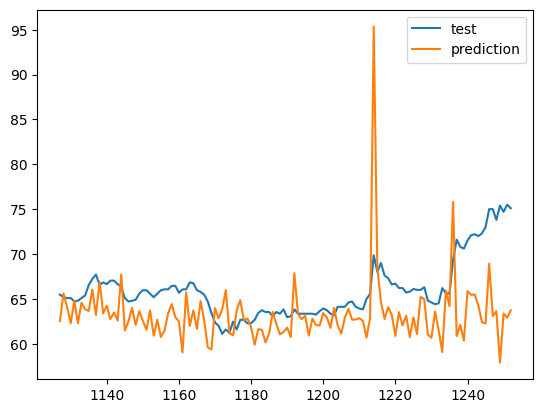

In [13]:
plt.plot(test.index, test['close'])
plt.plot(test.index, output['predict'])
plt.legend(['test','prediction'])
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
import numpy as np

# Calculate RMSE 
rmse_test = np.sqrt(mean_squared_error(test['close'], output['predict']))

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((test['close'] - output['predict']) / test['close'])) * 100
mape_test = mean_absolute_percentage_error(test['close'], output['predict'])

# Calculate MLSE 
msle_test = mean_squared_log_error(test['close'], output['predict'])

print("RMSE:", rmse_test*1000)
print("MAPE:", mape_test, "%")
print("MSLE:", msle_test)

RMSE: 5117.834698073431
MAPE: 5.263973104762514 %
MSLE: 0.005393987812618687
